### Imports and activation functions

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
from tqdm import tqdm
import time
import openpyxl
import scipy

### Display helper functions

In [3]:
# Helper function to display large matrices in a nicer way.
def display_matrix(M, num_columns=None):
    df = pd.DataFrame(M)
    if num_columns is None or num_columns > len(df.columns):
        num_columns = len(df.columns)
    print(df.iloc[:, :num_columns])


# Example use:
M = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
display_matrix(M, num_columns=3)
display_matrix(M, num_columns=2)

print("-------------------")


# Helper function to display window intervals
def display_windows(xmins, xmaxs):
    data = {
        "Window #": [f"Window {i+1}" for i in range(len(xmins))],
        "xmins": xmins,
        "xmaxs": xmaxs,
    }
    df = pd.DataFrame(data)
    print(df)


# Example use:
xmins = jnp.array([0, 2, 4])
xmaxs = jnp.array([1, 3, 5])
display_windows(xmins, xmaxs)

   0  1  2
0  1  2  3
1  4  5  6
2  7  8  9
   0  1
0  1  2
1  4  5
2  7  8
-------------------
   Window #  xmins  xmaxs
0  Window 1      0      1
1  Window 2      2      3
2  Window 3      4      5


### Init Interval

In [4]:
def initInterval(J, xmin, xmax, width=1.9, verbose=False):
    sd = (xmax - xmin) / J
    xc = jnp.linspace(xmin, xmax, J)
    xmins = xc - width * sd
    xmaxs = xc + width * sd
    if verbose:
        display_windows(xmins, xmaxs)
    return xmins, xmaxs


# Example use:
J = 5
xmin = 0
xmax = 1
xmins, xmaxs = initInterval(J, xmin, xmax, verbose=True)

   Window #  xmins  xmaxs
0  Window 1  -0.38   0.38
1  Window 2  -0.13   0.63
2  Window 3   0.12   0.88
3  Window 4   0.37   1.13
4  Window 5   0.62   1.38


### Basis Functions

In [5]:
@partial(jax.jit, static_argnums=(1,))
def phi(x, activation, weight, bias, mu, sd):
    # x = norm(mu,sd,x)
    x = activation(jnp.dot(x, weight) + bias)
    # x = unnorm(mu,sd,x)
    return x

@partial(jax.jit, static_argnums=(1,))
def phi_dx(x, activation_dx, weight, bias, mu, sd):
    # x = norm(mu,sd,x)
    x = jnp.dot(activation_dx(jnp.dot(x, weight) + bias), weight)
    # x = unnorm(mu,sd,x)
    return x


@partial(jax.jit, static_argnums=(1,))
def phi_dxx(x, activation_dxx, weight, bias, mu, sd):
    # x = norm(mu,sd,x)
    x = jnp.dot(activation_dxx(jnp.dot(x, weight) + bias), jnp.square(weight))
    # x = unnorm(mu,sd,x)
    return x

### Window Functions

In [6]:
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def window_hat_dx(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(
        condition,
        -2
        * jnp.pi
        * (1 + jnp.cos(jnp.pi * (x - mu) / sd))
        * jnp.sin(jnp.pi * (x - mu) / sd)
        / sd,
        0,
    )

def window_hat_dxx(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    pi_term = jnp.pi * (x - mu) / sd

    term1 = 2 * jnp.pi**2 * jnp.sin(pi_term) ** 2 / sd**2
    term2 = 2 * jnp.pi**2 * jnp.cos(pi_term) * (1 + jnp.cos(pi_term)) / sd**2

    result = term1 - term2
    return jnp.where(condition, result, 0)


### Partition of Unity Functions

In [7]:
def POU(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])

    return w_j / jnp.sum(w_k)


def POU_dx(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])

    dwdx = jnp.array([window_hat_dx(x, xmins[k], xmaxs[k]) for k in range(J)])
    dwjdx = window_hat_dx(x, xmins[j], xmaxs[j])

    return (dwjdx * jnp.sum(w_k) - w_j * jnp.sum(dwdx)) / jnp.sum(w_k) ** 2


def POU_dxx(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])

    dwdx = jnp.array([window_hat_dx(x, xmins[k], xmaxs[k]) for k in range(J)])
    dwjdx = window_hat_dx(x, xmins[j], xmaxs[j])

    dwdxx = jnp.array([window_hat_dxx(x, xmins[k], xmaxs[k]) for k in range(J)])
    dwjdxx = window_hat_dxx(x, xmins[j], xmaxs[j])

    sum_wk = jnp.sum(w_k)
    sum_dwdx = jnp.sum(dwdx)

    return (
        dwjdxx * sum_wk**2
        - 2 * dwjdx * sum_wk * sum_dwdx
        + 2 * w_j * sum_dwdx**2
        - w_j * jnp.sum(dwdxx) * sum_wk
    ) / sum_wk**3

### Loss Functions

In [8]:
# L1 Loss - Absolute Error
def calc_l1_loss(u, f_x):  # u - predicted, f_x - true
    loss = jnp.mean(jnp.abs(f_x - u)).item()
    print(f"Loss Value: {loss:.2e}")
    return loss


# Normalized L1 Loss - Absolute Error
def calc_normalized_l1_loss(
    a, M, b
):  # a - output weights, M - large solution matrix, b - RHS
    residual = M @ a - b
    l1_loss = jnp.mean(jnp.abs(residual))
    b_std = b.std()
    normalized_l1_loss = l1_loss / b_std
    print(f"Normalized L1 Loss Value: {normalized_l1_loss:.2e}")

    return normalized_l1_loss

### Functions for solving linear system

In [9]:
def least_squares_solver(M_csc, B, lmda, f, g):

    # M_csc = sp.csc_matrix(M)
    B_csc = sp.csc_matrix(B)

    LHS = M_csc.T @ M_csc + lmda * B_csc.T @ B_csc
    RHS = M_csc.T @ f + lmda * B_csc.T @ g

    start_time = time.time()
    a = splinalg.spsolve(LHS, RHS)
    end_time = time.time()

    elapsed_time = end_time - start_time

    lhs_condition_number = np.linalg.cond(LHS.toarray())

    print(f"Time taken for solver: {elapsed_time:.4f} seconds")
    return a, elapsed_time, lhs_condition_number

### Window plotting functions

In [10]:
def plot_window_hat(J, xmin_global, xmax_global, width, num_points=100):
    x = jnp.linspace(xmin_global, xmax_global, num_points)
    xmins, xmaxs = initInterval(J, xmin_global, xmax_global, width)

    plt.figure(figsize=(8, 6))
    for j in range(J):
        y = [window_hat(x[i], xmins[j], xmaxs[j]) for i in range(num_points)]
        plt.plot(x, y, label=f"Window {j+1} [{xmins[j]:.2f}, {xmaxs[j]:.2f}]")

    plt.title("Plot of window_hat function")
    plt.xlabel("x")
    plt.ylabel("window_hat(x)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_window_hat_dx(J, xmin_global, xmax_global, sd=None, num_points=100):
    x = jnp.linspace(xmin_global, xmax_global, num_points)
    xmins, xmaxs = initInterval(J, xmin_global, xmax_global, sd=sd)

    plt.figure(figsize=(8, 6))
    for j in range(J):
        y = [window_hat_dx(x[i], xmins[j], xmaxs[j]) for i in range(num_points)]
        plt.plot(x, y, label=f"Window {j+1} [{xmins[j]:.2f}, {xmaxs[j]:.2f}]")

    plt.title("Plot of window_hat function")
    plt.xlabel("x")
    plt.ylabel("window_hat(x)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_window_hat_dxx(J, xmin_global, xmax_global, sd=None, num_points=100):
    x = jnp.linspace(xmin_global, xmax_global, num_points)
    xmins, xmaxs = initInterval(J, xmin_global, xmax_global, sd=sd)

    plt.figure(figsize=(8, 6))
    for j in range(J):
        y = [window_hat_dxx(x[i], xmins[j], xmaxs[j]) for i in range(num_points)]
        plt.plot(x, y, label=f"Window {j+1} [{xmins[j]:.2f}, {xmaxs[j]:.2f}]")

    plt.title("Plot of window_hat function")
    plt.xlabel("x")
    plt.ylabel("window_hat(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

### Partition of unity plotting functions

In [11]:
def plot_POU(J, global_xmin, global_xmax):
    x_plot = jnp.linspace(global_xmin, global_xmax, 100)
    colors = ["b", "g", "r", "c", "m"]

    xmins, xmaxs, sd = initInterval(J, global_xmin, global_xmax)

    plt.figure(figsize=(10, 6))

    omega_j = jnp.zeros_like(x_plot)
    for j in range(J):
        omega_j = [POU(x, j, xmins, xmaxs, J) for x in x_plot]
        plt.plot(x_plot, omega_j, label=f"Window {j}", color=colors[j])

    plt.title("Window Functions")
    plt.xlabel("x")
    plt.ylabel("Window Function Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_POU_dx(J, global_xmin, global_xmax):

    x_plot = jnp.linspace(global_xmin, global_xmax, 100)
    colors = ["b", "g", "r", "c", "m"]
    xmins, xmaxs, sd = initInterval(J, global_xmin, global_xmax)
    plt.figure(figsize=(10, 6))

    omega_j = jnp.zeros_like(x_plot)
    for j in range(J):
        omega_j = [POU_dx(x, j, xmins, xmaxs, J) for x in x_plot]
        plt.plot(x_plot, omega_j, label=f"Window {j}", color=colors[j])

    plt.title("Window Functions")
    plt.xlabel("x")
    plt.ylabel("Window Function Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_POU_dxx(J, global_xmin, global_xmax):
    x_plot = jnp.linspace(global_xmin, global_xmax, 100)
    colors = ["b", "g", "r", "c", "m"]
    xmins, xmaxs, sd = initInterval(J, global_xmin, global_xmax)
    plt.figure(figsize=(10, 6))

    omega_j = jnp.zeros_like(x_plot)
    for j in range(J):
        omega_j = [POU_dxx(x, j, xmins, xmaxs, J) for x in x_plot]
        plt.plot(x_plot, omega_j, label=f"Window {j}", color=colors[j])

    plt.title("Window Functions")
    plt.xlabel("x")
    plt.ylabel("Window Function Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Function to plot solution

In [12]:
def plot_solution(x, u, f_solution, title):

    plt.figure(figsize=(10, 6))
    plt.plot(x, u, label="Solution u", marker="o")
    plt.plot(x, f_solution, label="Function f(x)", marker="x")
    plt.title(f"{title}")
    plt.xlabel("x")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Compute_M_entry
Function that calculates the residual value of the ODE

In [13]:
def compute_M_entry(x, l, j, J, c, weights, biases, xmins, xmaxs, sigmas):
    sigma, sigma_dx, sigma_dxx = sigmas[0], sigmas[1], sigmas[2]
    if J == 1:
        partition_dxx = 0
        partition_dx = 0
        partition = 1
    else:
        partition = POU(x[l], j, xmins, xmaxs, J)

        partition_dx = POU_dx(x[l], j, xmins, xmaxs, J)

        partition_dxx = POU_dxx(x[l], j, xmins, xmaxs, J)

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x[l], sigma, weights[c], biases[c], mu, sd)

    basis_dx = phi_dx(x[l], sigma_dx, weights[c], biases[c], mu, sd)

    basis_dxx = phi_dxx(x[l], sigma_dxx, weights[c], biases[c], mu, sd)

    u_tt = partition_dxx * basis + 2 * partition_dx * basis_dx + partition * basis_dxx
    u_t = partition_dx * basis + partition * basis_dx
    u = partition * basis

    m = 1
    d = 2
    mu_param = 2 * d
    omega_0 = 80
    k = omega_0**2

    entry = m * u_tt + mu_param * u_t + (k + 1) * u

    return entry

In [14]:
def compute_M_entry_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigma):
    sigma, sigma_dx, sigma_dxx = sigma, jax.grad(sigma), jax.grad(jax.grad(sigma))
    if J == 1:
        partition_dxx = 0
        partition_dx = 0
        partition = 1
    else:
        partition = POU(x, j, xmins, xmaxs, J)
        partition_dx = POU_dx(x, j, xmins, xmaxs, J)
        partition_dxx = POU_dxx(x, j, xmins, xmaxs, J)


    mu = (xmins[j] + xmaxs[j]) / 2.0
    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x, sigma, weights[c], biases[c], mu, sd)
    basis_dx = phi_dx(x, sigma_dx, weights[c], biases[c], mu, sd)
    basis_dxx = phi_dxx(x, sigma_dxx, weights[c], biases[c], mu, sd)

    u_tt = partition_dxx * basis + 2 * partition_dx * basis_dx + partition * basis_dxx
    u_t = partition_dx * basis + partition * basis_dx
    u = partition * basis

    m = 1
    d = 2
    mu_param = 2 * d
    omega_0 = 80
    k = omega_0**2

    entry = m * u_tt + mu_param * u_t + (k + 1) * u

    return entry

### Compute u and du value
Functions that combine partition of unity and basis functions to approximate u and du coefficients

In [15]:
def compute_u_value(x, l, j, J, c, weights, biases, xmins, xmaxs, sigma):
    if J == 1:
        partition = 1
    else:
        partition = POU(x[l], j, xmins, xmaxs, J)

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x[l], sigma, weights[c], biases[c], mu, sd)

    u = partition * basis

    return u


def compute_du_value(x, l, j, J, c, weights, biases, xmins, xmaxs, sigma):

    if J == 1:
        partition_dx = 0
        partition = 1
    else:
        partition = POU(x[l], j, xmins, xmaxs, J)
        partition_dx = POU_dx(x[l], j, xmins, xmaxs, J)

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0
    
    sigma_dx = jax.grad(sigma)

    basis = phi(x[l], sigma, weights[c], biases[c], mu, sd)
    basis_dx = phi_dx(x[l], sigma_dx, weights[c], biases[c], mu, sd)

    u_t = partition_dx * basis + partition * basis_dx

    return u_t

In [16]:
def compute_u_value_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigma):
    sigma, sigma_dx, sigma_dxx = sigma, jax.grad(sigma), jax.grad(jax.grad(sigma))
    if J == 1:
        partition = 1
    else:
        partition = POU(x, j, xmins, xmaxs, J)

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x, sigma, weights[c], biases[c], mu, sd)

    u = partition * basis

    return u


def compute_du_value_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigma):
    sigma, sigma_dx, sigma_dxx = sigma, jax.grad(sigma), jax.grad(jax.grad(sigma))

    if J == 1:
        partition_dx = 0
        partition = 1
    else:
        partition = POU(x, j, xmins, xmaxs, J)
        partition_dx = POU_dx(x, j, xmins, xmaxs, J)

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x, sigma, weights[c], biases[c], mu, sd)
    basis_dx = phi_dx(x, sigma_dx, weights[c], biases[c], mu, sd)

    u_t = partition_dx * basis + partition * basis_dx

    return u_t

In [28]:
def vectorized_matrix_entry(rows, columns, x_batch, J, C, weights, biases, xmins, xmaxs, sigma, compute_entry_func):
    def single_M_entry(idx):
        row = rows[idx]
        col = columns[idx]
        j = col // C  # Extract j from column index
        c = col % C   # Extract c from column index
        x = x_batch[row]
        #jax.debug.print("Processing idx: {idx}, row: {row}, col: {col}, j: {j}, c: {c}, x: {x}", idx=idx, row=row, col=col, j=j, c=c, x=x)
        entry_value = compute_entry_func(x, j, J, c, weights, biases, xmins, xmaxs, sigma)
        #jax.debug.print("Entry value: {entry_value}", entry_value=entry_value)
        return entry_value

    values = jax.vmap(single_M_entry)(jnp.arange(rows.shape[0]))
    jax.debug.print("Values shape: {values}", values=values.shape)
    return values

### Compute system functions
Functions that loop over the collocations, subdomains, neurons to build the pseudo-mass matrices using the appropriate compute function above

In [17]:
def vmap_compute_system_ODE_with_BCs(
    RHS_func,
    u,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigmas,
    title,
    lmda=1,
    plot_window=True,
):

    total_start_time = time.time()  # Start time for the entire function

    # Generate the weights and biases
    key = random.PRNGKey(0)
    key, subkey = random.split(key)
    weights = random.uniform(subkey, shape=(C,), minval=-R, maxval=R)

    key, subkey = random.split(key)
    biases = random.uniform(subkey, shape=(C,), minval=-R, maxval=R)

    xmins, xmaxs = initInterval(J, xmin, xmax, width=width)

    if plot_window:
        plot_window_hat(J, xmin, xmax, width)

    x_train = jnp.linspace(xmin, xmax, n_train)
    width = x_train[1] - x_train[0]

    def vectorized_M_entry(x_train, J, C, weights, biases, xmins, xmaxs, sigmas):
        Jarray = jnp.arange(J)
        Carray = jnp.arange(C)

        def single_M_entry(x, j, c):
            condition = jnp.logical_and(x >= xmins[j], x <= xmaxs[j])
            return jnp.where(
                condition,
                compute_M_entry_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigmas),
                0,
            )

        # Vectorize over x_train, Jarray, and Carray
        # for each C, J and x_train, compute the single M entry
        # returns matrix of size (n_train, J * C)
        vmap_M_entry = jax.vmap(jax.vmap(jax.vmap(single_M_entry, in_axes=(None, None, 0)),in_axes=(None, 0, None),),in_axes=(0, None, None),
        )

        # Reshape the result to match the shape of M_ode
        result = vmap_M_entry(x_train, Jarray, Carray)
        return result.reshape((x_train.shape[0], J * C))

    print("Creating M_ode...")
    start_time = time.time()
    M_ode = vectorized_M_entry(x_train, J, C, weights, biases, xmins, xmaxs, sigmas)
    print(f"M_ode created in {time.time() - start_time:.2f} seconds.")

    MD = np.diag(1.0 / np.max(np.abs(M_ode), axis=1))
    M_ode_scaled = MD @ M_ode
    print("M_ode scaled.")

    # Changed this to a u instead of the f
    exact_solution = MD @ RHS_func(x_train)
    print("exact_solution scaled.")

    # Initialize and compute B_train
    print("Creating B_train...")
    B_train = jnp.zeros((2, J * C))

    def single_B_train_entry(j, c):
        u_val = compute_u_value(
            x_train, 0, j, J, c, weights, biases, xmins, xmaxs, sigmas
        )
        du_val = compute_du_value(
            x_train, 0, j, J, c, weights, biases, xmins, xmaxs, sigmas
        )
        return u_val, du_val

    start_time = time.time()
    vmap_B_train_entry = jax.vmap(
        jax.vmap(single_B_train_entry, in_axes=(None, 0)), in_axes=(0, None)
    )
    u_vals, du_vals = vmap_B_train_entry(jnp.arange(J), jnp.arange(C))

    B_train = B_train.at[0].set(u_vals.reshape(J * C))
    B_train = B_train.at[1].set(du_vals.reshape(J * C))
    print(f"B_train created in {time.time() - start_time:.2f} seconds.")

    # Scaling B_train
    BD = np.diag(1.0 / np.max(np.abs(B_train), axis=1))
    B_ode_scaled = BD @ B_train
    print("B_train scaled")

    # Boundary conditions
    g_train = jnp.zeros(2)
    g_train = BD @ g_train.at[0].set(1)

    # Solve the system with boundary conditions
    start_time = time.time()
    a, elapsed_time, lhs_condition = least_squares_solver(
        M_ode_scaled, B_ode_scaled, lmda, exact_solution, g_train
    )
    print(f"a calculated in {time.time() - start_time:.2f} seconds.")

    x_test = jnp.linspace(xmin, xmax, n_test)

    def vectorized_u_entry(x_test, J, C, weights, biases, xmins, xmaxs, sigmas):
        Jarray = jnp.arange(J)
        Carray = jnp.arange(C)

        def single_u_entry(x, j, c):
            condition = jnp.logical_and(x >= xmins[j], x <= xmaxs[j])
            return jnp.where(
                condition,
                compute_u_value_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigmas),
                0,
            )

        # Vectorize over x_train, Jarray, and Carray
        vmap_u_entry = jax.vmap(
            jax.vmap(
                jax.vmap(single_u_entry, in_axes=(None, None, 0)),
                in_axes=(None, 0, None),
            ),
            in_axes=(0, None, None),
        )

        # Reshape the result to match the shape of M_ode
        result = vmap_u_entry(x_test, Jarray, Carray)
        return result.reshape((x_test.shape[0], J * C))

    print("Creating M_sol...")
    start_time = time.time()
    M_sol = vectorized_u_entry(x_test, J, C, weights, biases, xmins, xmaxs, sigmas)
    print(f"M_sol created in {time.time() - start_time:.2f} seconds.")

    u_test = M_sol @ a
    u_exact = u(x_test)

    # Plot the solution and print results.
    test_loss = calc_l1_loss(u_test, u_exact)
    print(f"Test Loss Value: {test_loss:.2e}")

    plot_solution(x_test, u_test, u_exact, title)

    print(f"Condition number of M_ode_scaled: {np.linalg.cond(M_ode_scaled):.2e}")
    print(f"Condition number of M_sol_scaled: {np.linalg.cond(M_sol):.2e}")
    print(f"Condition Number of LHS: {lhs_condition:.2e}")

    loss = [test_loss]
    u = [u_test]
    Ms = [M_ode_scaled, M_sol]
    B = [B_train]
    f = [exact_solution]
    x = [x_test]

    total_elapsed_time = time.time() - total_start_time  # Total time taken
    print(f"Total time taken: {total_elapsed_time:.2f} seconds.")

    return Ms, B, a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time

#jitted_compute_system_ODE_with_BCs = jax.jit(compute_system_ODE_with_BCs)

### Helper Functions for saving and loading results to and from .csv format
extract_FBPINN_PINN_results - requires an excel output from the main fbpinn library

In [18]:
def save_results_to_excel(
    Ms, B, a, us, losses, xs, fs, xmins, xmaxs, elapsed_time, lhs_condition, filename
):
    import openpyxl
    from openpyxl import Workbook

    # Create a new workbook
    workbook = Workbook()

    # Add matrices Ms to separate sheets
    for i, M in enumerate(Ms):
        sheet_name = f"Matrix_M_{i+1}"
        worksheet = workbook.create_sheet(sheet_name)
        M = jnp.asarray(M)  # Ensure it's a NumPy array if it's a JAX array
        for row in range(M.shape[0]):
            for col in range(M.shape[1]):
                worksheet.cell(row=row + 1, column=col + 1, value=float(M[row, col]))

    # Add matrix B to a separate sheet
    for i, B_matrix in enumerate(B):
        sheet_name = f"Matrix_B_{i+1}"
        worksheet = workbook.create_sheet(sheet_name)
        # Ensure it's a NumPy array if it's a JAX array
        B_matrix = jnp.asarray(B_matrix)
        for row in range(B_matrix.shape[0]):
            for col in range(B_matrix.shape[1]):
                worksheet.cell(
                    row=row + 1, column=col + 1, value=float(B_matrix[row, col])
                )

    # Add vector a to a sheet
    worksheet = workbook.create_sheet("Vector_a")
    a = jnp.asarray(a)
    for i in range(a.shape[0]):
        worksheet.cell(row=i + 1, column=1, value=float(a[i]))

    # Add us to a sheet
    for i, u in enumerate(us):
        sheet_name = f"U_{i+1}"
        worksheet = workbook.create_sheet(sheet_name)
        u = jnp.asarray(u)
        for j in range(u.shape[0]):
            worksheet.cell(row=j + 1, column=1, value=float(u[j]))

    # Add losses to a sheet
    worksheet = workbook.create_sheet("Losses")
    for i, loss in enumerate(losses):
        worksheet.cell(row=i + 1, column=1, value=float(loss))

    # Add xs to a sheet
    for i, x in enumerate(xs):
        sheet_name = f"X_{i+1}"
        worksheet = workbook.create_sheet(sheet_name)
        x = jnp.asarray(x)
        for j in range(x.shape[0]):
            worksheet.cell(row=j + 1, column=1, value=float(x[j]))

    # Add fs to a sheet
    for i, f in enumerate(fs):
        sheet_name = f"F_{i+1}"
        worksheet = workbook.create_sheet(sheet_name)
        f = jnp.asarray(f)
        for j in range(f.shape[0]):
            worksheet.cell(row=j + 1, column=1, value=float(f[j]))

    # Add xmins and xmaxs to a sheet
    worksheet = workbook.create_sheet("Intervals")
    for i in range(len(xmins)):
        worksheet.cell(row=i + 1, column=1, value=float(xmins[i]))
        worksheet.cell(row=i + 1, column=2, value=float(xmaxs[i]))

    # Add elapsed_time to a sheet
    worksheet = workbook.create_sheet("Elapsed_Time")
    worksheet.cell(row=1, column=1, value=float(elapsed_time))

    # Add condition numbers to a sheet
    worksheet = workbook.create_sheet("Condition_Numbers")
    worksheet.cell(row=1, column=1, value=float(lhs_condition))

    # Remove the default sheet created with the workbook
    default_sheet = workbook["Sheet"]
    workbook.remove(default_sheet)

    # Save the workbook
    workbook.save(filename)


def load_results_from_excel(filename):
    import openpyxl
    from openpyxl import load_workbook
    import numpy as np

    # Load the workbook
    workbook = load_workbook(filename)

    # Load matrices Ms from sheets
    Ms = []
    i = 1
    while f"Matrix_M_{i}" in workbook.sheetnames:
        sheet = workbook[f"Matrix_M_{i}"]
        M = np.array(
            [
                [
                    sheet.cell(row=row + 1, column=col + 1).value
                    for col in range(sheet.max_column)
                ]
                for row in range(sheet.max_row)
            ]
        )
        Ms.append(M)
        i += 1

    # Load matrix B from sheets
    Bs = []
    i = 1
    while f"Matrix_B_{i}" in workbook.sheetnames:
        sheet = workbook[f"Matrix_B_{i}"]
        B = np.array(
            [
                [
                    sheet.cell(row=row + 1, column=col + 1).value
                    for col in range(sheet.max_column)
                ]
                for row in range(sheet.max_row)
            ]
        )
        Bs.append(B)
        i += 1

    # Load vector a
    sheet = workbook["Vector_a"]
    a = np.array([sheet.cell(row=i + 1, column=1).value for i in range(sheet.max_row)])

    # Load us
    us = []
    i = 1
    while f"U_{i}" in workbook.sheetnames:
        sheet = workbook[f"U_{i}"]
        u = np.array(
            [sheet.cell(row=j + 1, column=1).value for j in range(sheet.max_row)]
        )
        us.append(u)
        i += 1

    # Load losses
    sheet = workbook["Losses"]
    losses = np.array(
        [sheet.cell(row=i + 1, column=1).value for i in range(sheet.max_row)]
    )

    # Load xs
    xs = []
    i = 1
    while f"X_{i}" in workbook.sheetnames:
        sheet = workbook[f"X_{i}"]
        x = np.array(
            [sheet.cell(row=j + 1, column=1).value for j in range(sheet.max_row)]
        )
        xs.append(x)
        i += 1

    # Load fs
    fs = []
    i = 1
    while f"F_{i}" in workbook.sheetnames:
        sheet = workbook[f"F_{i}"]
        f = np.array(
            [sheet.cell(row=j + 1, column=1).value for j in range(sheet.max_row)]
        )
        fs.append(f)
        i += 1

    # Load xmins and xmaxs
    sheet = workbook["Intervals"]
    xmins = np.array(
        [sheet.cell(row=i + 1, column=1).value for i in range(sheet.max_row)]
    )
    xmaxs = np.array(
        [sheet.cell(row=i + 1, column=2).value for i in range(sheet.max_row)]
    )

    # Load elapsed_time
    sheet = workbook["Elapsed_Time"]
    elapsed_time = sheet.cell(row=1, column=1).value

    # Load condition numbers
    sheet = workbook["Condition_Numbers"]
    lhs_condition = sheet.cell(row=1, column=1).value

    return Ms, Bs, a, us, losses, xs, fs, xmins, xmaxs, elapsed_time, lhs_condition


def extract_FBPINN_PINN_results(file_path):
    # Read the Excel file
    xls = pd.ExcelFile(file_path)

    # Extract data from the "results" sheet
    results_df = pd.read_excel(xls, sheet_name="results")
    u_pinn = results_df["u_pinn"].values
    u_fbpinn = results_df["u_fbpinn"].values

    # Extract data from the "time_loss" sheet
    time_loss_df = pd.read_excel(xls, sheet_name="time_loss")
    fbpinn_time_taken = time_loss_df["FBPINN_time_taken"].values
    fbpinn_l1_losses = time_loss_df["FBPINN_l1_losses"].values
    fbpinn_norm_l1_losses = time_loss_df["FBPINN_l1_norm_losses"].values
    pinn_time_taken = time_loss_df["PINN_time_taken"].values
    pinn_l1_losses = time_loss_df["PINN_l1_losses"].values
    pinn_norm_l1_losses = time_loss_df["PINN_l1_norm_losses"].values

    # Extract data from the "metrics" sheet
    metrics_df = pd.read_excel(xls, sheet_name="metrics")
    metrics = metrics_df.set_index("Metric")["Value"].to_dict()
    final_loss_value_pinn = metrics["final_loss_value_pinn"]
    final_loss_value_fbpinn = metrics["final_loss_value_fbpinn"]
    final_time_taken_pinn = metrics["final_time_taken_pinn"]
    final_time_taken_fbpinn = metrics["final_time_taken_fbpinn"]

    # Return all data in a dictionary for easy access
    data = {
        "u_pinn": u_pinn,
        "u_fbpinn": u_fbpinn,
        "fbpinn_time_taken": fbpinn_time_taken,
        "fbpinn_l1_losses": fbpinn_l1_losses,
        "fbpinn_l1_norm_losses": fbpinn_norm_l1_losses,
        "pinn_time_taken": pinn_time_taken,
        "pinn_l1_losses": pinn_l1_losses,
        "pinn_l1_norm_losses": pinn_norm_l1_losses,
        "final_loss_value_pinn": final_loss_value_pinn,
        "final_loss_value_fbpinn": final_loss_value_fbpinn,
        "final_time_taken_pinn": final_time_taken_pinn,
        "final_time_taken_fbpinn": final_time_taken_fbpinn,
    }

    return data

### Helper function to load condition numbers and network sizes

In [19]:
def extract_lhs_cond_network_size(activation, C, R, n_test, J_min, J_max):
    # Initialize empty lists to store the results
    lhs_conditions = []
    network_sizes = []
    network_sizes_no_n = []

    # Loop over the file numbers from J_min to J_max
    for i in range(J_min, J_max + 1):
        # Construct the filename based on the pattern
        filename = f"{activation}_J{i}_C{C}_ntest{n_test}_R{R}.xlsx"

        # Load the workbook
        workbook = openpyxl.load_workbook(filename, data_only=True)

        # Select the 'Condition_Numbers' sheet
        worksheet = workbook["Condition_Numbers"]

        # Get the lhs_condition number from the first cell (A1)
        lhs_condition = worksheet.cell(row=1, column=1).value

        # Append the lhs_condition number to the list
        lhs_conditions.append(lhs_condition)
        network_sizes.append(150 * 32 * i)
        network_sizes_no_n.append(32 * i)

    # Convert the lists to numpy arrays for easier manipulation
    lhs_conditions_array = np.array(lhs_conditions)
    network_sizes_array = np.array(network_sizes)
    network_sizes_no_n_array = np.array(network_sizes_no_n)

    return lhs_conditions_array, network_sizes_array, network_sizes_no_n_array

### Static ODE parameters and exact solution

In [20]:
# Damped Harmonic Oscillator parameters
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)


# Damped harmonic oscillator solution and its derivatives
def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega_0 * t)


def zero_RHS(t):
    return 0.0 * harm_u_exact(t)

### Testing for index generation

In [32]:
def generate_indices(C, xmins, xmaxs, x):
    """
    Generates row and column indices and col_ptrs for a CSC matrix format, based on which points in x fall
    within the ranges defined by xmins and xmaxs for each subdomain (j, c).
    """
    # Expand x, xmins, and xmaxs to perform the full batch condition check
    x_expanded = jnp.expand_dims(x, 1)  # (n, 1), for broadcasting
    xmins_expanded = jnp.expand_dims(xmins, 0)  # (1, J), for broadcasting
    xmaxs_expanded = jnp.expand_dims(xmaxs, 0)  # (1, J), for broadcasting

    # Condition check across the full batch
    inside = (x_expanded >= xmins_expanded) & (x_expanded <= xmaxs_expanded)  # (n, J) - Return True if x is within J subdomain
    inside = jnp.repeat(inside, C, axis=1)  # Repeat J times for each C subdomain to get (n, J * C) - Copy the boolean results for each C within each J

    # Find indices where the condition is True
    row_indices, col_indices = jnp.nonzero(inside)

    # Stack indices for output
    indices = jnp.stack([row_indices, col_indices], axis=1)

    return row_indices, col_indices


In [ ]:
def elmfbpinn(
    RHS_func,
    u,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    key,
    w_key,
    b_key,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=True,
    debug=False,
):
    total_start_time = time.time()  # Start time for the entire function
    #print(f"Total start time: {total_start_time}")

    if weights is None:
        weights = random.uniform(w_key, shape=(C,), minval=-R, maxval=R)  # shape=(C,) (32,)
        biases = random.uniform(b_key, shape=(C,), minval=-R, maxval=R)
    
    if debug:    
        print(f"weights: {weights}")
        print(f"biases: {biases}")

    xmins, xmaxs = initInterval(J, xmin, xmax, width=width, verbose=False)
    
    if debug:
        print(f"xmins: {xmins}")
        print(f"xmaxs: {xmaxs}")

    if plot_window:
        plot_window_hat(J, xmin, xmax, width)

    x_train = jnp.linspace(xmin, xmax, n_train)
    #print(f"x_train range: {x_train[0]} to {x_train[-1]}")

    # Generate indices for non-zero entries
    rows, columns = generate_indices(C, xmins, xmaxs, x_train)
        #print(f"rows shape: {rows.shape}, columns shape: {columns.shape}")
        #print(f"First few rows indices: {rows[:5]}")
        #print(f"First few columns indices: {columns[:5]}")

    print("Creating M_ode...")
    start_time = time.time()
    M_values = vectorized_matrix_entry(rows, columns, x_train, J, C, weights, biases, xmins, xmaxs, sigma, compute_M_entry_vmap)
        #  print(f"M_values shape: {M_values.shape}")

    # Scale the values
    M_values_scaled = M_values / jnp.max(jnp.abs(M_values))
    print(f"M_values scaled. Max value: {jnp.max(M_values_scaled)}")

    # Create the sparse matrix using row and column indices
    M_ode_sparse = scipy.sparse.csc_matrix((M_values_scaled, (rows, columns)), shape=(n_train, J * C))
    print(f"M_ode created in {time.time() - start_time:.2f} seconds.")

    # Exact solution
    exact_solution = RHS_func(x_train) / jnp.max(jnp.abs(M_values))
    print("exact_solution scaled.")

    # Initialize and compute B_train
    print("Creating B_train...")
    B_train = jnp.zeros((2, J * C))

    def single_B_train_entry(j, c):
        u_val = compute_u_value(
            x_train, 0, j, J, c, weights, biases, xmins, xmaxs, sigma
        )
        du_val = compute_du_value(
            x_train, 0, j, J, c, weights, biases, xmins, xmaxs, sigma
        )
        
        return u_val, du_val
    
    if debug:
        jax.debug.print("u_val: {u_val}, du_val: {du_val}", u_val=u_val, du_val=du_val)

    start_time = time.time()
    vmap_B_train_entry = jax.vmap(
        jax.vmap(single_B_train_entry, in_axes=(None, 0)), in_axes=(0, None)
    )
    u_vals, du_vals = vmap_B_train_entry(jnp.arange(J), jnp.arange(C))
        #print(f"u_vals shape: {u_vals.shape}")
        #print(f"du_vals shape: {du_vals.shape}")

    B_train = B_train.at[0].set(u_vals.reshape(J * C))
    B_train = B_train.at[1].set(du_vals.reshape(J * C))
    print(f"B_train created in {time.time() - start_time:.2f} seconds.")

    # Scaling B_train
    BD = jnp.diag(1.0 / jnp.max(jnp.abs(B_train), axis=1))
    B_ode_scaled = BD @ B_train
    print("B_train scaled.")

    # Boundary conditions
    g_train = jnp.zeros(2)
    g_train = BD @ g_train.at[0].set(1)

    # Solve the system with boundary conditions
    start_time = time.time()
    a, elapsed_time, lhs_condition = least_squares_solver(
        M_ode_sparse, B_ode_scaled, lmda, exact_solution, g_train
    )
    print(f"a calculated in {time.time() - start_time:.2f} seconds.")
    # print(f"a shape: {a.shape}")
    # print(f"First few values of a: {a[:5]}")

    x_test = jnp.linspace(xmin, xmax, n_test)

    print("Creating M_sol...")
    start_time = time.time()
    rows, columns = generate_indices(C, xmins, xmaxs, x_test)

    M_sol = vectorized_matrix_entry(rows, columns, x_test, J, C, weights, biases, xmins, xmaxs, sigma, compute_u_value_vmap)
    M_sol_sparse = scipy.sparse.csc_matrix((M_sol, (rows, columns)), shape=(x_test.shape[0], J * C))
    print(f"M_sol created in {time.time() - start_time:.2f} seconds.")

    u_test = M_sol_sparse @ a
    u_exact = u(x_test)

    # Plot the solution and print results.
    test_loss = calc_l1_loss(u_test, u_exact)
    print(f"Test Loss Value: {test_loss:.2e}")

    plot_solution(x_test, u_test, u_exact, title)

    print(f"Condition number of M_ode_sparse: {jnp.linalg.cond(M_ode_sparse.toarray()):.2e}")
    print(f"Condition number of M_sol_sparse: {jnp.linalg.cond(M_sol_sparse.toarray()):.2e}")
    print(f"Condition Number of LHS: {lhs_condition:.2e}")

    loss = [test_loss]
    u = [u_test]
    Ms = [M_sol, M_ode_sparse, M_sol_sparse]
    B = [B_train]
    f = [exact_solution]
    x = [x_test]

    total_elapsed_time = time.time() - total_start_time  # Total time taken
    print(f"Total time taken: {total_elapsed_time:.2f} seconds.")

    return Ms, B, a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time, rows, columns





Creating M_ode...
Values shape: (Array(16832, dtype=int32, weak_type=True),)
M_values scaled. Max value: 0.9945811629295349
M_ode created in 0.28 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.41 seconds.
B_train scaled.
Time taken for solver: 0.0043 seconds
a calculated in 0.08 seconds.
Creating M_sol...
Values shape: (Array(33792, dtype=int32, weak_type=True),)
M_sol created in 0.11 seconds.
Loss Value: 3.96e-03
Test Loss Value: 3.96e-03


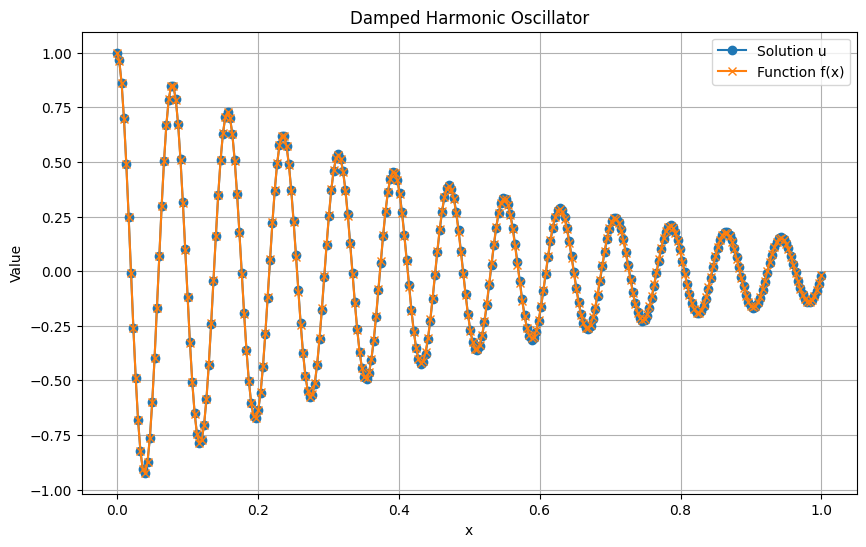

Condition number of M_ode_sparse: 1.28e+07
Condition number of M_sol_sparse: 2.56e+09
Condition Number of LHS: 3.09e+11
Total time taken: 2.18 seconds.


In [35]:
import sys
sys.path.append('../')
from matrix_builder_old import elmfbpinn_old

RHS_func = zero_RHS
u = harm_u_exact
n_train = 150
n_test = 300
J = 20
C = 32
R = 25
xmin = 0.0
xmax = 1.0
width = 1.9
sigma = jnp.sin
title = "Damped Harmonic Oscillator"
key = random.PRNGKey(0)
w_key, b_key = random.split(key)

results = elmfbpinn_old(
    RHS_func,
    u,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    key,
    w_key,
    b_key,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
    debug=False,
)

Creating M_ode...
Values shape: (Array(16832, dtype=int32, weak_type=True),)
M_values scaled. Max value: 0.9748742580413818
M_ode created in 0.89 seconds.
exact_solution scaled.
Creating B_train...
B_train created in 0.51 seconds.
B_train scaled.
Time taken for solver: 0.0042 seconds
a calculated in 0.04 seconds.
Creating M_sol...
Values shape: (Array(33792, dtype=int32, weak_type=True),)
M_sol created in 0.17 seconds.
Loss Value: 1.70e-02
Test Loss Value: 1.70e-02


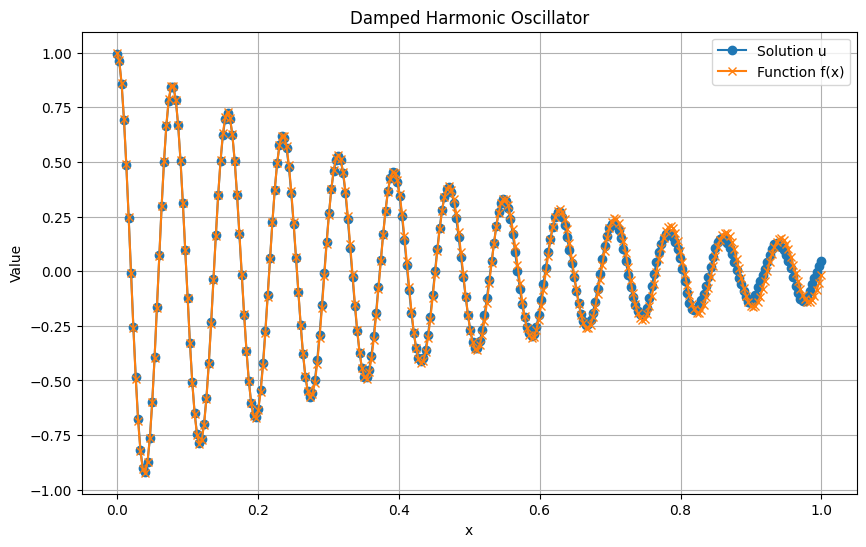

Condition number of M_ode_sparse: 1.30e+07
Condition number of M_sol_sparse: 3.07e+09
Condition Number of LHS: 1.84e+11
Total time taken: 1.84 seconds.


In [38]:
J = 20 # number of windows
C = 32 # number of neurons
n_train = 150 # number of training points
n_test = 300  # number of test points
R = 25 # sample range for weights and biases
width = 1.9  # width of the windows
activation = "sin"  # Name of activation function, for the file name
# List of activations as defined above
sigma = jnp.sin
global_xmin, global_xmax = 0, 1
key = random.PRNGKey(0)
RHS_func = zero_RHS
exact_solution = harm_u_exact
title = "Damped Harmonic Oscillator"
w_key, b_key = random.split(key)

# Initialize lists to store the results
Results = []
smaller_Condition_Numbers = []
training_network_size = []
test_network_size = []
loss_values = []


(
    Ms_index,
    Bs_v,
    a_v,
    u_v,
    loss_v,
    x_v,
    f_v,
    lhs_condition_v,
    xmins_v,
    xmaxs_v,
    elapsed_time_v,
    rows,
    columns,
) = elmfbpinn(
    RHS_func,
    exact_solution,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    key,
    w_key,
    b_key,
    weights=None,
    biases=None,
    lmda=1,
    plot_window=False,
    debug=False,
)

# smaller_Condition_Numbers.append(lhs_condition)
# training_network_size.append(J * C * n_train)
# test_network_size.append(J * C * n_test)
# loss_values.append(loss[-1])

# Generate the filename based on the parameters
filename = f"{activation}_J{J}_C{C}_ntest{n_test}_R{R}_vmap.xlsx"
# Results.append([Ms, a, u, loss, x, f, xmins, xmaxs, elapsed_time, filename])

# Save the results to an excel file
##save_results_to_excel(
##    Ms, Bs, a, u, loss, x, f, xmins, xmaxs, elapsed_time, lhs_condition, filename
##)